In [3]:
import torch
import pandas
import numpy as np
print(torch.__version__)
print(torch.cuda.is_available())

2.1.0
True


In [4]:
# 加载数据文件
global_data_path = r"D:\work\大数据挑战赛\global\global\global_data.npy"
temp_data_path = r"D:\work\大数据挑战赛\global\global\temp.npy"
wind_data_path = r"D:\work\大数据挑战赛\global\global\wind.npy"
global_data = np.load(global_data_path)
temp_data = np.load(temp_data_path)
wind_data = np.load(wind_data_path)

In [5]:
print("Global data shape:", global_data.shape)
print("Temperature data shape:", temp_data.shape)
print("Wind speed data shape:", wind_data.shape)
print("Missing values in global data:", np.isnan(global_data).sum())
print("Missing values in temperature data:", np.isnan(temp_data).sum())
print("Missing values in wind speed data:", np.isnan(wind_data).sum())

Global data shape: (5848, 4, 9, 3850)
Temperature data shape: (17544, 3850, 1)
Wind speed data shape: (17544, 3850, 1)
Missing values in global data: 0
Missing values in temperature data: 0
Missing values in wind speed data: 0


## 协变量意义
协变量中包含以下四个不同含义的变量，在数据中按照以下顺序排列：

十米高度的矢量纬向风速10U，正方向为东方（m/s）

十米高度的矢量经向风速10V，正方向为北方（m/s）

两米高度的温度值T2M（℃）

均一海平面气压MSL（Pa）

## 因变量意义

因变量包括两个不同含义的变量：

两米高度的温度值（℃）

两米高度的风速的绝对值（m/s）


In [6]:
# 查看第0个站点第0小时第0个网格的信息
print(global_data[0,:,0,0])

[ 6.98229980e+00 -2.57963562e+00  8.31696472e+00  1.02845938e+05]


In [7]:
# 温度的统计特性
print("Temperature data - Mean:", np.mean(temp_data))
print("Temperature data - Standard Deviation:", np.std(temp_data))
print("Global data temp - Mean:", np.mean(global_data[:,2,:,:]))
print("Global data temp - Standard Deviation::", np.std(global_data[:,2,:,:]))
print("Wind data - Mean:", np.mean(wind_data))
print("Wind data - Standard Deviation:", np.std(wind_data))

Temperature data - Mean: 10.909699163809309
Temperature data - Standard Deviation: 11.886215980137134
Global data temp - Mean: 10.970819669261376
Global data temp - Standard Deviation:: 11.857681157292994
Wind data - Mean: 3.407640365448504
Wind data - Standard Deviation: 2.8277380147703433


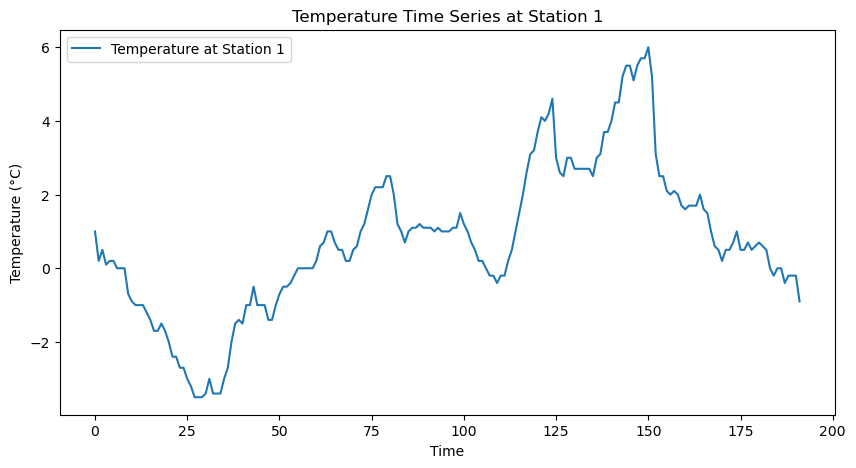

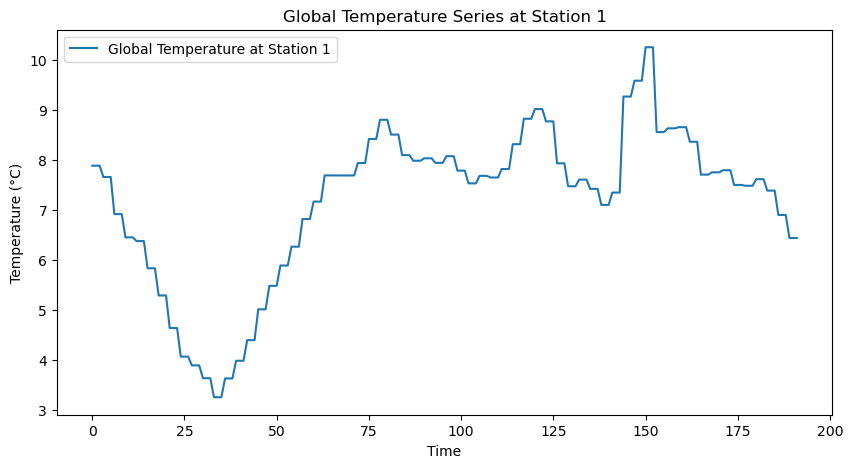

In [8]:
# 温度走势 取第一个站点
import matplotlib.pyplot as plt

# 间隔3小时采样重复3次-->相当于间隔1小时采样
global_data = np.repeat(global_data, 3, axis=0)[:len(temp_data), :, :, :]

# Plotting the first station's temperature data as an example
plt.figure(figsize=(10, 5))
plt.plot(temp_data[:192, 0, 0], label='Temperature at Station 1')
plt.title('Temperature Time Series at Station 1')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

# Plotting the first station's wind data
plt.figure(figsize=(10, 5))
plt.plot(np.mean(global_data[:192,2,:,0],axis=1), label='Global Temperature at Station 1')
plt.title('Global Temperature Series at Station 1')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

## 平滑趋势

### 1. 使用简单移动平均法 (SMA)

简单移动平均是通过计算数据点的前n个数据点的平均值来平滑数据。

In [16]:
# 定义误差统计

import numpy as np

def mean_squared_error(true_values, predictions):
    """计算均方误差"""
    return np.mean((true_values - predictions) ** 2)

def root_mean_squared_error(true_values, predictions):
    """计算均方根误差"""
    return np.sqrt(mean_squared_error(true_values, predictions))

def mean_absolute_error(true_values, predictions):
    """计算平均绝对误差"""
    return np.mean(np.abs(true_values - predictions))


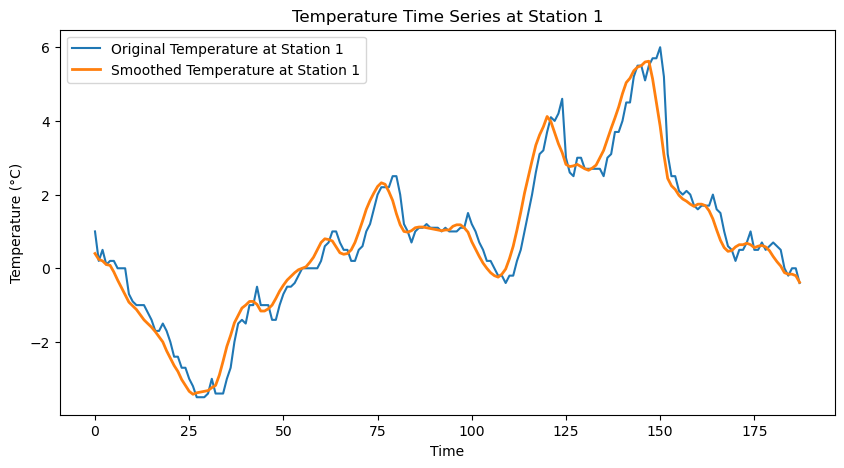

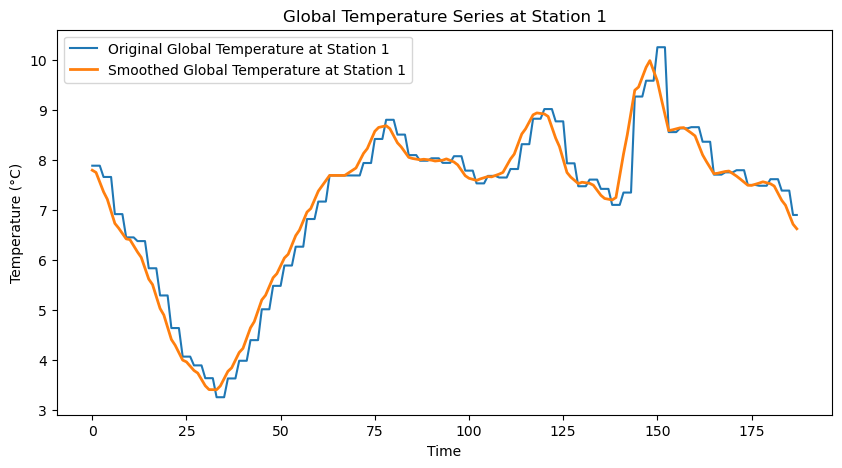

Station Temperature Data:
MSE: 0.2259872340425532
RMSE: 0.4753811460739195
MAE: 0.3429787234042553

Global Temperature Data:
MSE: 0.10589975273225442
RMSE: 0.32542242198756743
MAE: 0.23374774653297228


In [17]:
import numpy as np
import matplotlib.pyplot as plt

# 定义移动平均函数
def moving_average(data, window_size):
    """计算移动平均."""
    return np.convolve(data, np.ones(window_size), 'valid') / window_size

# 应用移动平均
window_size = 5  # 可以调整窗口大小来看不同的平滑效果
temp_smoothed = moving_average(temp_data[:192, 0, 0], window_size)
global_temp_smoothed = moving_average(np.mean(global_data[:192, 2, :, 0], axis=1), window_size)

# 绘制原始和平滑后的温度数据
plt.figure(figsize=(10, 5))
plt.plot(temp_data[:192 - window_size + 1, 0, 0], label='Original Temperature at Station 1')
plt.plot(temp_smoothed, label='Smoothed Temperature at Station 1', linewidth=2)
plt.title('Temperature Time Series at Station 1')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

# 绘制全球数据的平滑温度
plt.figure(figsize=(10, 5))
plt.plot(np.mean(global_data[:192, 2, :, 0], axis=1)[:192 - window_size + 1], label='Original Global Temperature at Station 1')
plt.plot(global_temp_smoothed, label='Smoothed Global Temperature at Station 1', linewidth=2)
plt.title('Global Temperature Series at Station 1')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

# 计算站点温度数据的误差
original_temp = temp_data[:192 - window_size + 1, 0, 0]
mse_temp = mean_squared_error(original_temp, temp_smoothed)
rmse_temp = root_mean_squared_error(original_temp, temp_smoothed)
mae_temp = mean_absolute_error(original_temp, temp_smoothed)

# 计算全球温度数据的误差
original_global_temp = np.mean(global_data[:192, 2, :, 0], axis=1)[:192 - window_size + 1]
mse_global_temp = mean_squared_error(original_global_temp, global_temp_smoothed)
rmse_global_temp = root_mean_squared_error(original_global_temp, global_temp_smoothed)
mae_global_temp = mean_absolute_error(original_global_temp, global_temp_smoothed)

# 打印误差结果
print("Station Temperature Data:")
print("MSE:", mse_temp)
print("RMSE:", rmse_temp)
print("MAE:", mae_temp)

print("\nGlobal Temperature Data:")
print("MSE:", mse_global_temp)
print("RMSE:", rmse_global_temp)
print("MAE:", mae_global_temp)


### 2. 使用LOWESS平滑
LOWESS（Locally Weighted Scatterplot Smoothing）是一种强大的非参数平滑技术，用于生成平滑曲线，这里使用statsmodels库实现

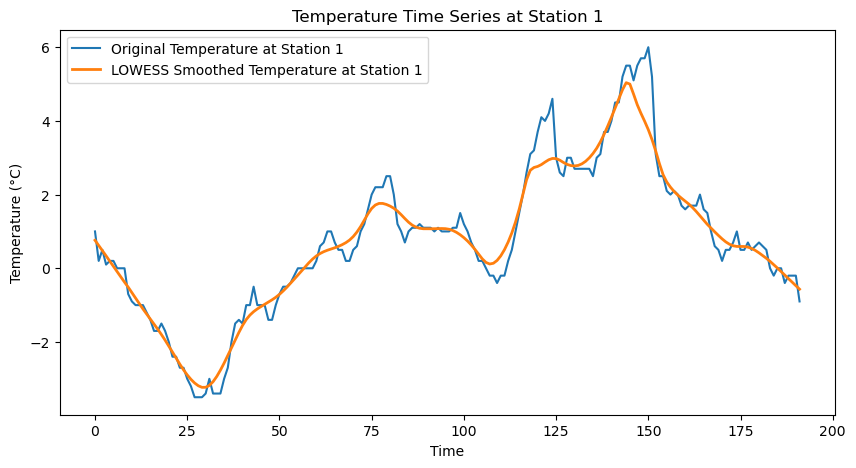

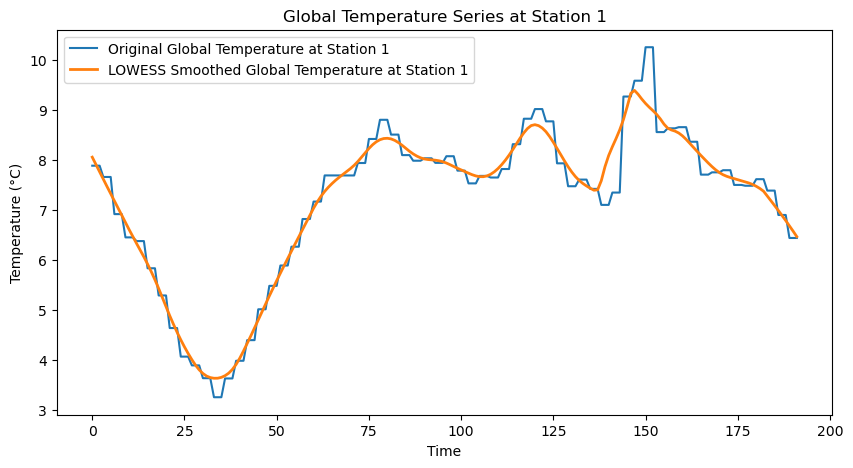

Station Temperature Data:
MSE: 0.19836639890585805
RMSE: 0.4453834290876324
MAE: 0.2971800127283695

Global Temperature Data:
MSE: 0.08163501667797841
RMSE: 0.2857184220136644
MAE: 0.18561700046532092


In [18]:
import statsmodels.api as sm

# LOWESS平滑
lowess = sm.nonparametric.lowess

temp_lowess = lowess(temp_data[:192, 0, 0], np.arange(192), frac=0.1)[:, 1]  # frac是平滑参数
global_temp_lowess = lowess(np.mean(global_data[:192, 2, :, 0], axis=1), np.arange(192), frac=0.1)[:, 1]

# 绘制LOWESS平滑后的温度数据
plt.figure(figsize=(10, 5))
plt.plot(temp_data[:192, 0, 0], label='Original Temperature at Station 1')
plt.plot(temp_lowess, label='LOWESS Smoothed Temperature at Station 1', linewidth=2)
plt.title('Temperature Time Series at Station 1')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

# 绘制全球数据的LOWESS平滑温度
plt.figure(figsize=(10, 5))
plt.plot(np.mean(global_data[:192, 2, :, 0], axis=1), label='Original Global Temperature at Station 1')
plt.plot(global_temp_lowess, label='LOWESS Smoothed Global Temperature at Station 1', linewidth=2)
plt.title('Global Temperature Series at Station 1')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

# 计算站点温度数据的误差
original_temp = temp_data[:192, 0, 0]
mse_temp = mean_squared_error(original_temp, temp_lowess)
rmse_temp = root_mean_squared_error(original_temp, temp_lowess)
mae_temp = mean_absolute_error(original_temp, temp_lowess)

# 计算全球温度数据的误差
original_global_temp = np.mean(global_data[:192, 2, :, 0], axis=1)
mse_global_temp = mean_squared_error(original_global_temp, global_temp_lowess)
rmse_global_temp = root_mean_squared_error(original_global_temp, global_temp_lowess)
mae_global_temp = mean_absolute_error(original_global_temp, global_temp_lowess)

# 打印误差结果
print("Station Temperature Data:")
print("MSE:", mse_temp)
print("RMSE:", rmse_temp)
print("MAE:", mae_temp)

print("\nGlobal Temperature Data:")
print("MSE:", mse_global_temp)
print("RMSE:", rmse_global_temp)
print("MAE:", mae_global_temp)


In [10]:
# Assuming the covariates are in the second dimension as 4 covariates
for i in range(4):
    print(f"Covariate {i+1} - Mean:", np.mean(global_data[:, i, :, :]))
    print(f"Covariate {i+1} - Standard Deviation:", np.std(global_data[:, i, :, :]))


Covariate 1 - Mean: 0.4153127330974494
Covariate 1 - Standard Deviation: 3.221055441448079
Covariate 2 - Mean: 0.15400509599183812
Covariate 2 - Standard Deviation: 3.06585248883787
Covariate 3 - Mean: 10.970819669244293
Covariate 3 - Standard Deviation: 11.857681157293092
Covariate 4 - Mean: 101457.96024612083
Covariate 4 - Standard Deviation: 951.7565955218972


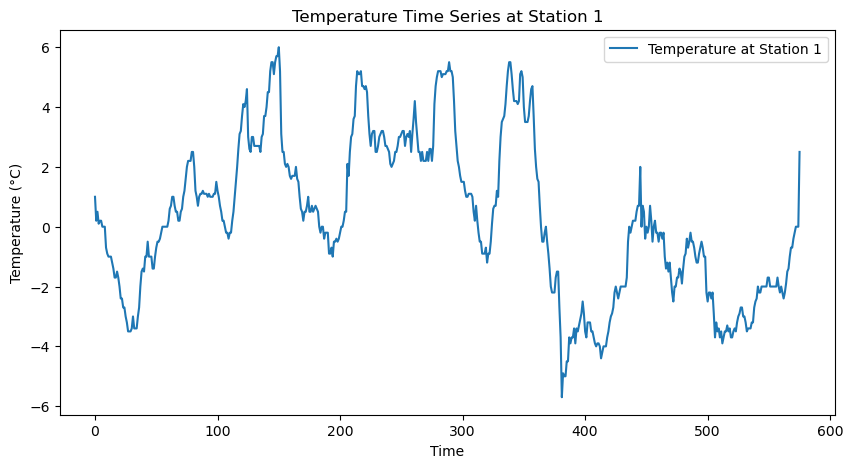

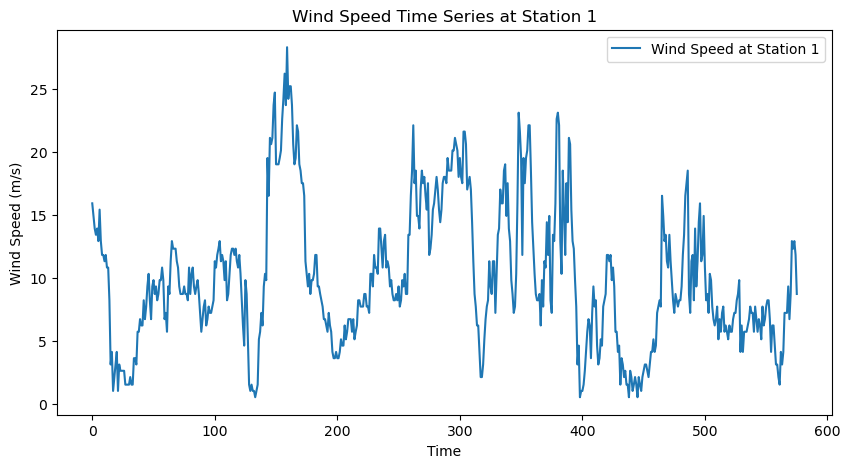

In [11]:
import matplotlib.pyplot as plt

# Plotting the first station's temperature data as an example
plt.figure(figsize=(10, 5))
plt.plot(temp_data[:192*3, 0, 0], label='Temperature at Station 1')
plt.title('Temperature Time Series at Station 1')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

# Plotting the first station's wind data
plt.figure(figsize=(10, 5))
plt.plot(wind_data[:192*3, 0, 0], label='Wind Speed at Station 1')
plt.title('Wind Speed Time Series at Station 1')
plt.xlabel('Time')
plt.ylabel('Wind Speed (m/s)')
plt.legend()
plt.show()


In [12]:
# 如何做分析
